In [143]:
import numpy as np
import scipy as sp
import math
import random
from scipy.optimize.slsqp import approx_jacobian
import matplotlib.pyplot as plt
import sys
from sympy import Symbol,diff
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
sys.path.append('../GaussianProcess/')

In [144]:
import gaussianKernel
import gaussianProcessRegression

# データ点準備

In [145]:
def stateFunction(x):
        return 0.2*x +  25*x/(1+x**2) + 8*np.cos(1.2 * x) + np.random.normal(loc= 0,scale = 0.5)

In [146]:
def observationFunction(x):
    return np.sin(x/10) + np.random.normal(loc = 0,scale = 0.05)

In [193]:
# 学習用データ 外れ値なし
time_steps = 51
Xt = np.array([])
for i in range(400):
    Xt=np.append(Xt,[random.uniform(-30, 30)])
Xt = np.sort(Xt)
Xt_1 = np.array([stateFunction(x) for x in Xt])
Y =  np.array([ observationFunction(x) for x in Xt])

状態方程式の実際の挙動


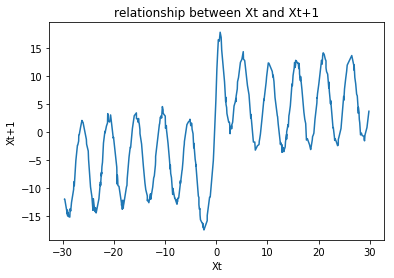

観測方程式の実際の挙動


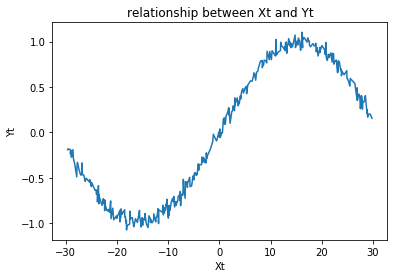

実際の状態の時間経過の値


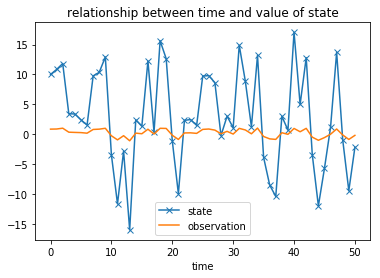

In [194]:
# 実際のデータ 外れ値なし
realXt = np.zeros(time_steps)
realXt[0]= 10
for i in range(time_steps):
    if i != 0:
        realXt[i] = stateFunction(realXt[i-1])
realYt = np.zeros(time_steps)
for i in range(time_steps):
    realYt[i] = observationFunction( realXt[i] )
time_steps_array = np.linspace(start=0,stop=50,num=time_steps)
print('状態方程式の実際の挙動')
plt.plot(Xt,Xt_1)
plt.title('relationship between Xt and Xt+1')
plt.xlabel('Xt')
plt.ylabel('Xt+1')
plt.show()
print('観測方程式の実際の挙動')
plt.plot(Xt,Y)
plt.title('relationship between Xt and Yt')
plt.xlabel('Xt')
plt.ylabel('Yt')
plt.show()
print('実際の状態の時間経過の値')
plt.plot(time_steps_array,realXt , label='state',marker = 'x')
plt.plot(time_steps_array,realYt,label = 'observation')
plt.title('relationship between time and value of state')
plt.xlabel('time')
plt.legend()
plt.show()

# ガウス過程

In [149]:
# ガウスカーネル
import numpy as np
import scipy as sp
import math
import random
from scipy.optimize.slsqp import approx_jacobian
import matplotlib.pyplot as plt

class GaussianKernel(object):
    # カーネル関数のパラメータa,bを初期化
    def __init__(self, params):
        assert np.shape(params) == (2,)
        self.__params = params

    # カーネル関数のパラメータa,bを返す
    def get_params(self):
        return np.copy(self.__params)

     # x,yを入力としてカーネル関数の値を計算 PRML式(6.63)
    def __call__(self, x, y):
        return (self.__params[0])**2*np.exp(-0.5 * self.__params[1] * (x - y) ** 2)

    # x,yを入力とした時のカーネル関数のパラメータでの微分を計算
    def derivatives(self, x, y):
        sq_diff = (x - y) ** 2
        # パラメータaでの微分
        delta_0 = 2*self.__params[0]*np.exp(-0.5 * self.__params[1] * sq_diff)
        # パラメータbでの微分
        delta_1 = -0.5 * sq_diff * self.__params[0]**2*np.exp(-0.5 * self.__params[1] * sq_diff)
        return (delta_0, delta_1)

    # カーネル関数のパラメータを更新
    def update_parameters(self, updates):
        assert np.shape(updates) == (2,)
        self.__params = updates

In [150]:
# ガウス過程
import numpy as np
import scipy as sp
import math
import random
from scipy.optimize.slsqp import approx_jacobian
import matplotlib.pyplot as plt

class GaussianProcessRegression(object):
    # カーネル関数とノイズの精度パラメータの初期化
    def __init__(self, kernel, beta= 1.0):
        self.kernel = kernel
        self.beta = beta
        kernelParameter = kernel.get_params()
        self.hyperParameter = np.append(beta,kernelParameter).T

    # カーネル関数のパラメータ推定を行わずに回帰
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.setK(x,y)

    # カーネル関数のパラメータの推定を行う回帰
    def fit_kernel(self, x, y, learning_rate=10**(-5), iter_max=5):
        self.x = x
        self.y = y
        for i in range(iter_max):
            print(self.hyperParameter)
            self.setK(x,y)
            self.setC()
            likelihood = np.array(self.likelihood(),dtype=np.float64)
            self.kernel.update_parameters(learning_rate*likelihood[1:])
            self.hyperParameter = self.hyperParameter + learning_rate*likelihood
        
    def likelihood(self):
        print(np.linalg.inv(self.C),(self.calucurateDiffC()))
        CdiffC = np.linalg.inv(self.C).dot(self.calucurateDiffC())
        return -0.5*np.trace(CdiffC) + 0.5*self.y.dot(self.y.T.dot(np.linalg.inv(self.C).dot(CdiffC)))
    
    def calucurateDiffC(self):
        diffC = np.zeros((len(self.x),len(self.x),len(self.hyperParameter)))
        diffC1 = np.zeros((len(self.x),len(self.x)))
        diffC2 = np.zeros((len(self.x),len(self.x)))
        diffC3 = np.zeros((len(self.x),len(self.x)))
        for i in range(len(self.x)):
            for j in range(len(self.x)):
                diff1, diff2 =  self.kernel.derivatives(self.x[i],self.x[j])
                diffC[i][j][0] = 1 if i==j else 0
                diffC[i][j][1] = diff1
                diffC[i][j][2] = diff2
                diffC1[i][j] = 1 if i==j else 0
                diffC2[i][j] = diff1
                diffC3[i][j] = diff2
        return diffC
    
    def setC(self):
        self.C = self.K + self.beta*np.eye(len(self.x))
    
    def setK(self,x,y):
        self.K = np.zeros([len(x),len(x)])
        for i in range(len(x)):
            for j in range(len(x)):
                self.K[i][j] = self.kernel(x[i],x[j])
    
    def kernels(self,x):
        return np.array([self.kernel(x,_x) for _x in self.x]).T
    
    def kernels_dif(self,x):
        params = self.kernel.get_params()
        return np.array([- params[1]*(self.x[i]-x)*params[0]**2 *np.exp(-0.5*params[1]*(self.x[i]-x)**2) for i in range(len(self.x))]).T
    
    # 予測分布を出力
    def predict_dist(self, x):
        K = self.kernel(*np.meshgrid(x, self.x, indexing='ij'))
        # 予測分布の平均を計算 PRML式(6.66)
        mean = K.dot(self.precision).dot(self.t)
        # 予測分布の分散を計算 PRML式(6.67)
        var = self.kernel(x, x) + 1 / self.beta - np.sum(K.dot(self.precision) * K, axis=1)
        return mean.ravel(), np.sqrt(var.ravel())
    
    def mean(self,x):
        return self.kernels(x).T.dot(np.linalg.inv(self.K + self.beta*np.eye(len(self.x)))).dot(self.y)
    
    def mean_j(self,x):
        return -self.kernels_dif(x).T.dot(np.linalg.inv(self.K + self.beta*np.eye(len(self.x)))).dot(self.y)
    
    def var(self,x):
        return self.kernel(x,x)- self.kernels(x).T.dot(np.linalg.inv(self.K+ self.beta*np.eye(len(self.x)))).dot(self.kernels(x))

In [151]:
# stateKernel = GaussianKernel(params=np.array([4.0, 4.0]))
# te_x = np.array([1,2])
# te_y = np.array([2,4])
# stateRegression = GaussianProcessRegression(kernel=stateKernel, beta=0.7)
# np.set_printoptions(precision=2)
# stateRegression.fit_kernel(te_x,te_y)

## 状態方程式

### ガウス過程

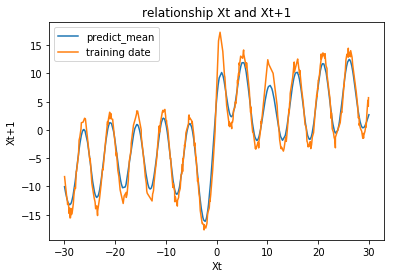

In [152]:
stateKernel = GaussianKernel(params=np.array([1.937, 0.4]))
stateRegression = GaussianProcessRegression(kernel=stateKernel, beta=4.126)
stateRegression.fit(Xt,Xt_1)
test_x = np.array([])
for i in range(500):
    test_x=np.append(test_x,[random.uniform(-30, 30)])
test_x= np.sort(test_x)
test_y = np.array([stateRegression.mean(x) for x in test_x])
test_y_std = np.array([stateRegression.var(x) for x in test_x])
plt.plot(test_x,test_y, label='predict_mean')
plt.plot(Xt,Xt_1, label='training date')
plt.title('relationship Xt and Xt+1')
plt.xlabel('Xt')
plt.ylabel('Xt+1')
# plt.ylim(-50,50)
# plt.fill_between(test_x, test_y - test_y_std, test_y + test_y_std, color="pink", alpha=0.5, label="predict_std")
plt.legend()
plt.show()

### 多項式フィッティング

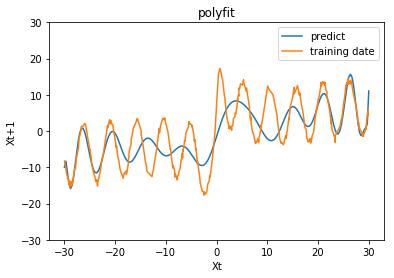

In [187]:
polyfy_f = np.poly1d(np.polyfit(Xt,Xt_1, 25))
polyfy_test_y = np.poly1d(np.polyfit(Xt,Xt_1, 25))(test_x)
plt.plot(test_x,polyfy_test_y,label='predict')
plt.title('polyfit')
plt.xlabel('Xt')
plt.ylabel('Xt+1')
plt.plot(Xt,Xt_1, label='training date')
plt.ylim(-30,30)
plt.legend()
plt.show()

polyfy_f_j = polyfy_f.deriv()

## 観測方程式

### ガウス過程

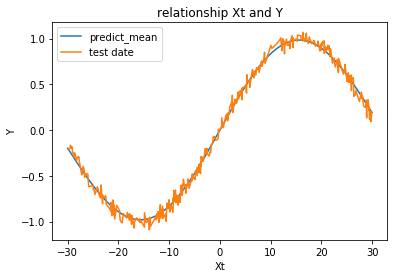

In [154]:
observationKernel = GaussianKernel(params=np.array([0.999, 0.002]))
# print(vars(stateKernel))
observationRegression = GaussianProcessRegression(kernel=observationKernel, beta=0.198)
observationRegression.fit(Xt, Y)
test_x = np.linspace(start=-30,stop=30,num=200)
test_y = np.array([observationRegression.mean(x) for x in test_x])
test_y_std = np.array([observationRegression.var(x) for x in test_x])
plt.plot(test_x,test_y, label='predict_mean')
plt.plot(Xt,Y, label='test date')
plt.title('relationship Xt and Y')
plt.xlabel('Xt')
plt.ylabel('Y')
plt.legend()
plt.show()

### 多項式フィッティング

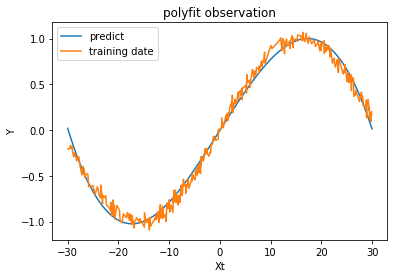

In [155]:
polyfy_h = np.poly1d(np.polyfit(Xt,Y, 4))
polyfy_test_y2 = np.poly1d(np.polyfit(Xt,Y, 4))(test_x)
plt.plot(test_x,polyfy_test_y2,label='predict')
plt.title('polyfit observation')
plt.xlabel('Xt')
plt.ylabel('Y')
plt.plot(Xt,Y, label='training date')
plt.legend()
plt.show()

polyfy_h_j = polyfy_h.deriv(1)

## EKF

In [167]:
# EKF
# #!/usr/bin/env python
# # -*- coding: utf-8 -*-
# # https://satomacoto.blogspot.com/2011/06/python_22.htm

class Ekf(object):
    # 初期化
    def __init__(self,stateFunction,observationFunction,stateFunction_j,observationFunction_j,
                 y,noise_s = np.random.normal(loc = 0,scale = 0.5), noise_o= np.random.normal(loc = 0,scale = 0.05),theta = 0,t = 50):
        #状態方程式、観測方程式
        #jはヤコビアン
        self.steps = 0
        self.noise_s = noise_s
        self.noise_o = noise_o
        self.theta = theta
        self.t = t
        self.stateFunction = stateFunction
        self.observationFunction = observationFunction
        self.stateFunction_j = stateFunction_j
        self.observationFunction_j = observationFunction_j
        self.x = np.zeros(t+1)
        self.x[0] = 10
        self.y = y #観測値
        self.P = np.zeros(t+1)
        self.P[0] = 1
        self.K = np.zeros(t+1)
    
    def updateParams(self):
        steps = self.steps
        assumed_x = self.stateFunction(self.x[steps])
        self.K[steps] = self.P[steps]*self.observationFunction_j(assumed_x)/(self.observationFunction_j(assumed_x)**2*self.P[steps]
                                                                             +self.noise_o**2)
        self.x[steps+1] = assumed_x + self.K[steps]*(self.y[steps+1]-self.observationFunction(assumed_x))
        self.P[steps+1] = self.stateFunction_j(self.x[steps+1])**2*(self.P[steps]**(-1)
                                                                 +self.observationFunction_j(assumed_x)**2*self.noise_o**(-2)+self.theta)**(-1)+self.noise_s**2
        self.steps = steps +1
#         print(assumed_x,self.x[self.steps],realXt[steps+1],self.observationFunction(assumed_x),self.y[steps+1])
    def filtering(self):
        self.steps = 0
        for i in range(self.t):
            self.updateParams()
            
    def show(self):
        test_t = np.array([x for x in range(self.t+1)])
        plt.plot(test_t,self.x,self.observationFunction(assumed_x))

In [168]:
def calucurateRMSE(ekf):
    rmse_sum = 0
    for i in range(len(realXt)):
        rmse_sum = rmse_sum + (ekf.x[i]-realXt[i])**2
    return  ((1/(ekf.t+1))*rmse_sum)**0.5

### 外れ値なし

In [182]:
def showEKFGraph(ekf,X,Y):
    test_t = np.array([_t for _t  in range(ekf.t+1)])
    plt.plot(test_t,ekf.x, marker = 'x')
    plt.plot(test_t,X, marker = 'o', label='true value')
    plt.title('relationship between true value and predicted value')
    plt.xlabel('time')
    plt.legend()
    plt.show()

In [177]:
def showEKFGraph(sRegression,oRegression,X,Y):
    nomalEkf = Ekf(stateFunction=sRegression.mean,observationFunction=oRegression.mean,
            stateFunction_j=sRegression.mean_j,observationFunction_j=oRegression.mean_j,y=Y)
    nomalEkf.filtering()
    riskHedgeEkf = Ekf(stateFunction=sRegression.mean,observationFunction=oRegression.mean,
                stateFunction_j=sRegression.mean_j,observationFunction_j=oRegression.mean_j,y=Y,theta=0.7)
    riskHedgeEkf.filtering()
    riskAcceptEkf = Ekf(stateFunction=sRegression.mean,observationFunction=oRegression.mean,
                stateFunction_j=sRegression.mean_j,observationFunction_j=oRegression.mean_j,y=Y,theta=-0.7)
    riskAcceptEkf.filtering()
    print('RSMEの値')
    print('θ=0 : ',calucurateRMSE(nomalEkf))
    print('θ=-0.7 : ',calucurateRMSE(riskHedgeEkf))
    print('θ=0.7 : ',calucurateRMSE(riskAcceptEkf))
    test_t = np.array([_t for _t  in range(nomalEkf.t+1)])
    plt.plot(test_t,nomalEkf.x,label='theta = 0', marker = 'x')
    plt.plot(test_t,riskHedgeEkf.x,label='theta = 0.7')
    plt.plot(test_t,riskAcceptEkf.x,label='theta = -0.7')
    plt.plot(test_t,X, marker = 'o', label='true value')

    plt.title('relationship between true value and predicted value')
    plt.xlabel('time')
#     plt.ylim(-50,50)
    plt.legend()
    plt.show()

RSMEの値
θ=0 :  2.36484754002
θ=-0.7 :  2.64207665395
θ=0.7 :  3.13125701775


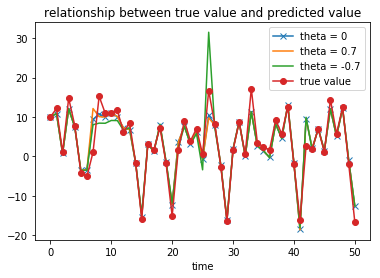

In [171]:
showEKFGraph(sRegression=stateRegression,oRegression=observationRegression,X=realXt,Y=realYt)

### 観測に外れ値あり

RSMEの値
θ=0 :  16.5695600099
θ=-0.7 :  14.0241378509
θ=0.7 :  17.3281035376


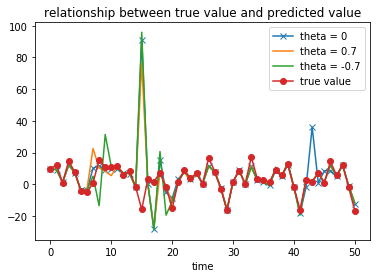

In [161]:
# 外れ値
outLinerY = np.copy(realYt)
outLinerY[15] = outLinerY[15] + 3
outLinerY[17] = outLinerY[17] - 3
showEKFGraph(sRegression=stateRegression,oRegression=observationRegression,X=realXt,Y=outLinerY)
# test_t = np.array([_t for _t  in range(myekf.t+1)])
# plt.plot(test_t,myekf.x,label='theta = 0')
# plt.plot(test_t,riskHedgeEkf.x,label='theta = 0.0005')
# plt.plot(test_t,riskAcceptEkf.x,label='theta = -0.0005')
# plt.plot(t,realXt , label='true value')
# plt.title('relationship between true value and predicted value')
# plt.xlabel('time')
# plt.ylim(-50,50)
# plt.legend()
# plt.show()

### 状態に外れ値ありの場合

RSMEの値
θ=0 :  5.0739862607
θ=-0.7 :  3.62676551457
θ=0.7 :  5.280954581


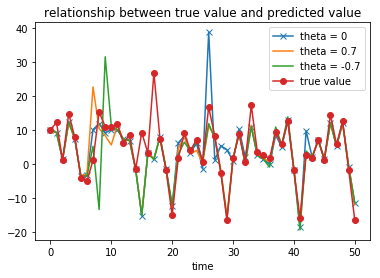

In [162]:
# 状態外れ値
outLinerX = np .copy(realXt)
outLinerX[15] = outLinerX[15] + 25
outLinerX[17] = outLinerX[17] + 25
showEKFGraph(sRegression=stateRegression,oRegression=observationRegression,X=outLinerX,Y=realYt)

# 多項式フィッティング

In [188]:
polyEKF = Ekf(stateFunction=polyfy_f,observationFunction= polyfy_h,stateFunction_j=polyfy_f_j,observationFunction_j=polyfy_h_j, y = realYt)

In [189]:
polyEKF.filtering()

In [190]:
print(polyEKF.x)

[ 10.          10.60155523   0.01601292  10.57432509   4.59808165
  -0.09734625  -5.09812393  -0.20394415  11.10367908   6.20239513
  10.5391641    5.82304063   7.65934004   7.48188253  -1.143003
 -11.90680004   2.76594966   2.53914274   8.39211208  -1.14679748
 -10.92576827   0.48193537   7.94128644   4.16041461   8.07180728
   0.95194328  10.62783673   4.34097965   1.29781891 -11.0007213
   0.95485912   8.90758203   0.12765726  10.74719401   0.97328696
   1.62328978   1.78580497   9.43228054   5.05854374  11.04850833
  -2.08935327 -12.87576304   1.54285058   2.76254721   7.95507476
   1.79190991  11.4796374    4.36203587  10.42327983  -1.57168067
 -12.70601381]


In [195]:
# showEKFGraph(ekf=polyEKF,X=realXt,Y=realYt)

In [196]:
calucurateRMSE(polyEKF)

10.32873427878647

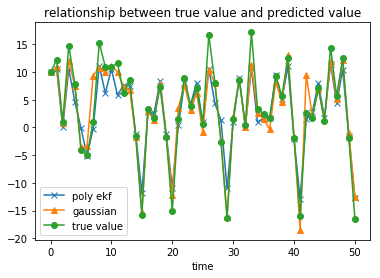

In [186]:
gaussianEkf = Ekf(stateFunction=stateRegression.mean,observationFunction=observationRegression.mean,
            stateFunction_j=stateRegression.mean_j,observationFunction_j=observationRegression.mean_j,y=realYt)
gaussianEkf.filtering()
test_t = np.array([_t for _t  in range(polyEKF.t+1)])
plt.plot(test_t,polyEKF.x, marker = 'x', label = 'poly ekf')
plt.plot(test_t,gaussianEkf.x, marker = '^', label = 'gaussian')
plt.plot(test_t,realXt, marker = 'o', label='true value')
plt.title('relationship between true value and predicted value')
plt.xlabel('time')
plt.legend()
plt.show()